In [1]:
# install.packages("tidymodels")
# install.packages("infer")
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(tidymodels))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(infer))
suppressPackageStartupMessages(library(GGally))
# library(tidyverse)
# library(infer)
# library(repr)
# library(tidymodels)
# library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(100)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


In [2]:
climate_1951 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_1951_P1D.csv", show_col_types = FALSE)
climate_1952 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_1952_P1D.csv", show_col_types = FALSE)
climate_1953 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_1953_P1D.csv", show_col_types = FALSE)
climate_1954 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_1954_P1D.csv", show_col_types = FALSE)
climate_1955 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_1955_P1D.csv", show_col_types = FALSE)
climate_2001 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_2001_P1D.csv", show_col_types = FALSE)
climate_2002 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_2002_P1D.csv", show_col_types = FALSE)
climate_2003 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_2003_P1D.csv", show_col_types = FALSE)
climate_2004 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_2004_P1D.csv", show_col_types = FALSE)
climate_2005 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_2005_P1D.csv", show_col_types = FALSE)

In [3]:
climate_50s <- rbind(climate_1951, 
                     climate_1952,
                     climate_1953,
                     climate_1954,
                     climate_1955)
climate_00s <- rbind(climate_2001, 
                     climate_2002,
                     climate_2003,
                     climate_2004,
                     climate_2005)

In [4]:
climate_50s <- climate_50s %>%
                  mutate(Year = "1951-1955")
climate_50s

Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),⋯,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
<dbl>,<dbl>,<chr>,<dbl>,<date>,<chr>,<chr>,<chr>,<lgl>,<dbl>,⋯,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<chr>,<chr>,<lgl>
-122.36,49.03,ABBOTSFORD A,1100030,1951-01-01,1951-1955,01,01,NA,4.4,⋯,0.0,NA,21.3,NA,NA,NA,NA,NA,NA,NA
-122.36,49.03,ABBOTSFORD A,1100030,1951-01-02,1951-1955,01,02,NA,6.1,⋯,0.0,NA,32.0,NA,NA,NA,NA,NA,NA,NA
-122.36,49.03,ABBOTSFORD A,1100030,1951-01-03,1951-1955,01,03,NA,5.0,⋯,0.5,NA,1.3,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-122.36,49.03,ABBOTSFORD A,1100030,1955-12-29,1951-1955,12,29,NA,1.7,⋯,0,NA,0,NA,0,NA,NA,NA,<31,NA
-122.36,49.03,ABBOTSFORD A,1100030,1955-12-30,1951-1955,12,30,NA,3.9,⋯,0,NA,0,NA,0,NA,NA,NA,<31,NA
-122.36,49.03,ABBOTSFORD A,1100030,1955-12-31,1951-1955,12,31,NA,0.6,⋯,0,NA,0,NA,0,NA,NA,NA,<31,NA


In [5]:
climate_00s <- climate_00s %>%
                  mutate(Year = "2001-2005")
climate_00s

Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),⋯,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
<dbl>,<dbl>,<chr>,<dbl>,<date>,<chr>,<chr>,<chr>,<lgl>,<dbl>,⋯,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<chr>,<chr>,<chr>
-122.36,49.03,ABBOTSFORD A,1100030,2001-01-01,2001-2005,01,01,NA,10.0,⋯,0,NA,0.0,NA,0,NA,NA,NA,<31,NA
-122.36,49.03,ABBOTSFORD A,1100030,2001-01-02,2001-2005,01,02,NA,9.8,⋯,0,NA,0.6,NA,0,NA,NA,NA,<31,NA
-122.36,49.03,ABBOTSFORD A,1100030,2001-01-03,2001-2005,01,03,NA,11.2,⋯,0,NA,8.0,NA,0,NA,NA,NA,<31,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-122.36,49.03,ABBOTSFORD A,1100030,2005-12-29,2001-2005,12,29,NA,7.7,⋯,0,NA,1.0,NA,0,NA,NA,NA,<31,NA
-122.36,49.03,ABBOTSFORD A,1100030,2005-12-30,2001-2005,12,30,NA,8.0,⋯,0,NA,9.6,NA,0,NA,NA,NA,<31,NA
-122.36,49.03,ABBOTSFORD A,1100030,2005-12-31,2001-2005,12,31,NA,7.0,⋯,0,NA,17.8,NA,0,NA,NA,NA,<31,NA


In [6]:
climate_change <- rbind(climate_50s,
                        climate_00s) 
climate_change <- climate_change %>%
                    mutate(Year = as.factor(Year))

In [7]:
climate_change

Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),⋯,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
<dbl>,<dbl>,<chr>,<dbl>,<date>,<fct>,<chr>,<chr>,<lgl>,<dbl>,⋯,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<chr>,<chr>,<chr>
-122.36,49.03,ABBOTSFORD A,1100030,1951-01-01,1951-1955,01,01,NA,4.4,⋯,0.0,NA,21.3,NA,NA,NA,NA,NA,NA,NA
-122.36,49.03,ABBOTSFORD A,1100030,1951-01-02,1951-1955,01,02,NA,6.1,⋯,0.0,NA,32.0,NA,NA,NA,NA,NA,NA,NA
-122.36,49.03,ABBOTSFORD A,1100030,1951-01-03,1951-1955,01,03,NA,5.0,⋯,0.5,NA,1.3,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-122.36,49.03,ABBOTSFORD A,1100030,2005-12-29,2001-2005,12,29,NA,7.7,⋯,0,NA,1.0,NA,0,NA,NA,NA,<31,NA
-122.36,49.03,ABBOTSFORD A,1100030,2005-12-30,2001-2005,12,30,NA,8.0,⋯,0,NA,9.6,NA,0,NA,NA,NA,<31,NA
-122.36,49.03,ABBOTSFORD A,1100030,2005-12-31,2001-2005,12,31,NA,7.0,⋯,0,NA,17.8,NA,0,NA,NA,NA,<31,NA


In [8]:
Climate_change_rename <- climate_change %>%
    select("Year", "Month", "Max Temp (°C)", "Min Temp (°C)",
           "Mean Temp (°C)", "Heat Deg Days (°C)", "Cool Deg Days (°C)", 
           "Total Rain (mm)", "Total Precip (mm)") %>%
    rename("Max_Temp" = "Max Temp (°C)",
         "Min_Temp" = "Min Temp (°C)",
         "Mean_Temp" = "Mean Temp (°C)",
         "Heat_Deg_Days" = "Heat Deg Days (°C)",
         "Cool_Deg_Days" = "Cool Deg Days (°C)",
         "Total_Rain" = "Total Rain (mm)",
         "Total_Precip" = "Total Precip (mm)")
Climate_change_rename

Year,Month,Max_Temp,Min_Temp,Mean_Temp,Heat_Deg_Days,Cool_Deg_Days,Total_Rain,Total_Precip
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1951-1955,01,4.4,2.8,3.6,14.4,0,21.3,21.3
1951-1955,01,6.1,1.1,3.6,14.4,0,32.0,32.0
1951-1955,01,5.0,3.3,4.2,13.8,0,0.8,1.3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2001-2005,12,7.7,2.7,5.2,12.8,0,1.0,1.0
2001-2005,12,8.0,5.1,6.6,11.4,0,9.6,9.6
2001-2005,12,7.0,5.4,6.2,11.8,0,17.8,17.8


In [9]:
station_temp <- Climate_change_rename %>%
    filter(!is.na(Mean_Temp)) %>%
    select(Year, Mean_Temp)
station_temp

Year,Mean_Temp
<fct>,<dbl>
1951-1955,3.6
1951-1955,3.6
1951-1955,4.2
⋮,⋮
2001-2005,5.2
2001-2005,6.6
2001-2005,6.2


H_0: The mean of the Daily Mean Temperature in the 1950s is the same as the mean of the Daily Mean Temperature in the 2000s. 


calculate observed test statistic

In [17]:
obs_diff_in_temp <- station_temp %>%
    specify(formula = Mean_Temp ~ Year) %>%
    calculate(stat = "diff in means", order = c("2001-2005", "1951-1955"))
obs_diff_in_temp

stat
<dbl>
1.742059


Simulating from the null distribution

In [18]:
null_diff_in_temp <- station_temp %>%
    specify(formula = Mean_Temp ~ Year) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("2001-2005", "1951-1955"))
null_diff_in_temp

replicate,stat
<int>,<dbl>
1,0.1704272
2,-0.0516977
3,-0.0543264
⋮,⋮
998,-0.2512596
999,-0.1530120
1000,-0.3715225


visualize and get p-value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


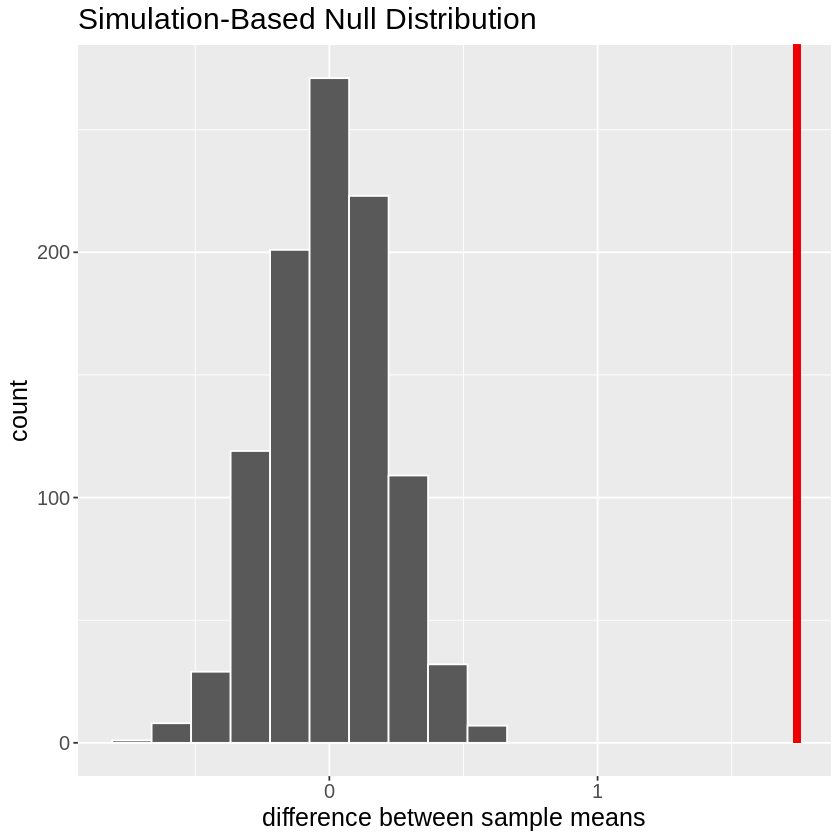

In [20]:
diff_in_temp_plot <- null_diff_in_temp %>%
    visualize(bins = 10) +
    shade_p_value(obs_stat = obs_diff_in_temp, direction = "right") +
    xlab("difference between sample means") +
    theme(text = element_text(size = 15))
diff_in_temp_plot
p_value <- null_diff_in_temp %>%
    get_p_value(obs_stat = obs_diff_in_temp, direction = "right")
p_value

We should never report a p-value of 0 because this suggests that making a Type I error is impossible. But this is too bold of a claim to make. Since we used 1000 reps to calculate the sample, we should report:

The p-value is < 0.001, we reject the null hypothesis at the 5% significant level. 

### Confidence interval

replicate,stat
<int>,<dbl>
1,1.913215
2,1.789817
3,1.832396
⋮,⋮
998,1.833956
999,1.962318
1000,1.329293


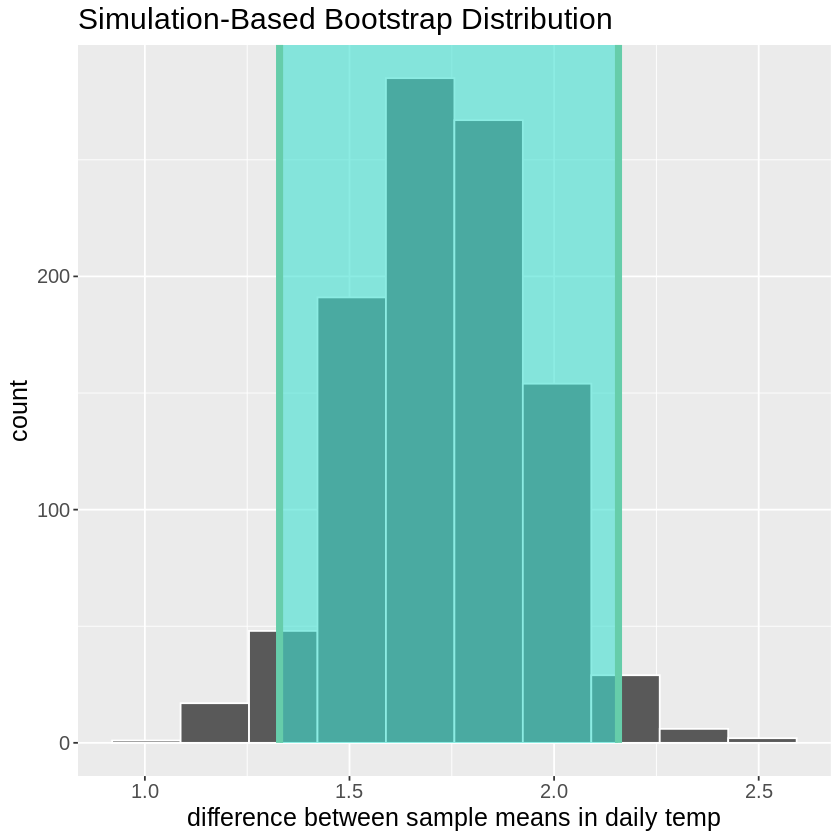

In [22]:
diff_in_temp_bootstrap_dist <- station_temp %>%
    specify(formula = Mean_Temp ~ Year) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("2001-2005", "1951-1955"))
diff_in_temp_bootstrap_dist

diff_in_temp_ci <- 
     diff_in_temp_bootstrap_dist %>% 
     get_confidence_interval(level = 0.95, type = "percentile")

diff_in_temp_ci_plot <- diff_in_temp_bootstrap_dist %>%
    visualize(bins = 10) +
    shade_ci(diff_in_temp_ci) +
    xlab("difference between sample means in daily temp") +
    theme(text = element_text(size = 15))
diff_in_temp_ci_plot

notice that the value 0 is not included in our confidence interval, again suggesting that $$\bar{x}_{2005-2001}$$ and $$\bar{x}_{1955-1951}$$ are truly different!